# Rafay's Shopify Summer 2022 Challenge Submission

## Question 1a/b
* My answer here depends on the context of the final metric and requires some business knowledge. Instead, I present a few possible solutions that I would then work with the Business team to refine.
* First, I would argue that looking at the value of the entire order may be flawed (again, depending on the context) as there may be many pairs of shoes in one order. Thus, a cost per item may be better to look at.
* Second, Store 78 has a very high cost per item, and potentially sells luxury shoes. We may want to exclude this store in our calculation as it is not representative of the rest of the dataset.
* Third, Store 42 seems to sell around 2000 pairs of shoes in one order, and may be a shoe wholesaler. Again, we may want to exclude wholesalers as they are not representative of non-wholesale clients.
* Lastly, if we wish to look at the entire order value and not exclude any stores, then using the Median or quartiles may be a better indication of how much the average order is for. Medians and percentiles are usually very informative to look at data with skews or outliers, as is the case here.

## Question 1c
* Cost Per Item (This is just Order Amount / Total Items in Order)
 * Including Store 78: $387.74

 * Excluding Store 78 (Since this may be a luxury shoe store): $152.48

* Non-wholesaler (i.e. excluding Store 42) AOV
 * $754.79

* Median and Percentiles of AOV:
 * 25th Percentile : $163

 * 50th Percentile : $284

 * 75th Percentile : $390

 * 90th Percentile: $531

### Note: My analysis for Q1 is below the answers to Q2.

 ## Question 2

### How many orders were shipped by Speedy Express in total?

**Answer: 54**. Note that Speedy Express is ShipperID=1.

```
SELECT COUNT(*) FROM Orders WHERE ShipperID=1
```

## What is the last name of the employee with the most orders?

**Answer: Peacock**.

```
SELECT COUNT(*), Employees.LastName FROM 
Orders, Employees
ON Orders.EmployeeID=Employees.EmployeeID
GROUP BY Employees.EmployeeID
ORDER BY COUNT(*) DESC
LIMIT 1
```

### What product was ordered the most by customers in Germany?

**Answer: As measured by order frequency, Gorgonzola Telino.**

**Answer: As measured by total order quantity, Boston Crab Meat.**

```
WITH GermanCustomers AS (
	SELECT CustomerID
    FROM Customers
    WHERE Country="Germany"
),
GermanOrders AS (
	SELECT ProductID, Quantity, Orders.OrderID
    FROM GermanCustomers
    LEFT JOIN Orders
    ON GermanCustomers.CustomerID=Orders.CustomerID
    LEFT JOIN OrderDetails
    ON Orders.OrderID=OrderDetails.OrderID
)
SELECT 
  ProductName,
  SUM(Quantity),
  COUNT(*)
FROM GermanOrders
LEFT JOIN Products
ON GermanOrders.ProductID=Products.ProductID
WHERE GermanOrders.OrderID IS NOT NULL
GROUP BY ProductName
ORDER BY Sum(Quantity) DESC
LIMIT 2
```

# Analysis for Question 1

In [1]:
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
import pandas as pd

# setup
gc = gspread.authorize(GoogleCredentials.get_application_default())

# read data and put it in a dataframe
gsheets = gc.open_by_url('https://docs.google.com/spreadsheets/d/16i38oonuX1y1g7C_UAmiK9GkY7cS-64DfiDMNiR41LM/edit#gid=0')

In [2]:
# Load Data
sheets = gsheets.worksheet('Sheet1').get_all_values()
df = pd.DataFrame(sheets[1:], columns=sheets[0])

# Basic typing, we define our numeric, datetime and string columns and cast object type (default) to required types
numeric_cols = ['order_id', 'shop_id', 'user_id', 'order_amount', 'total_items']
time_cols = ['created_at']
str_cols = ['payment_method']

# Cast
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric)
df[time_cols] = df[time_cols].apply(pd.to_datetime)
df[str_cols] = df[str_cols].astype(str)

# Confirm casting worked
df.dtypes

order_id                   int64
shop_id                    int64
user_id                    int64
order_amount               int64
total_items                int64
payment_method            object
created_at        datetime64[ns]
dtype: object

Now that we have our data loaded, we can start getting a basic idea of what we have here. Note that I have inspected the the CSV manually, so I kind of know what to expect going into this.

          order_id      shop_id      user_id   order_amount  total_items
count  5000.000000  5000.000000  5000.000000    5000.000000   5000.00000
mean   2500.500000    50.078800   849.092400    3145.128000      8.78720
std    1443.520003    29.006118    87.798982   41282.539349    116.32032
min       1.000000     1.000000   607.000000      90.000000      1.00000
25%    1250.750000    24.000000   775.000000     163.000000      1.00000
50%    2500.500000    50.000000   849.000000     284.000000      2.00000
75%    3750.250000    75.000000   925.000000     390.000000      3.00000
max    5000.000000   100.000000   999.000000  704000.000000   2000.00000


Text(0, 0.5, 'Frequency of Orders')

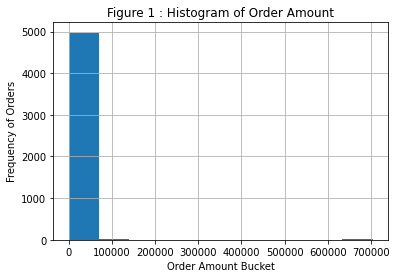

In [10]:
# Basic descriptive stats
print(df.describe())

# Histogram of Order Amount, the column of interest
plt = df.order_amount.hist()
plt.set_title('Figure 1 : Histogram of Order Amount')
plt.set_xlabel('Order Amount Bucket')
plt.set_ylabel('Frequency of Orders')

By looking at the mean of order_amount, we see that the AOV of $3145.13 is confirmed. 

### Interesting Observations

*   We see that order_amount has a max of $704,000, which is definitely pushing our average up. There are only a few orders like this, majority of orders (>4900) have a much smaller order amount.
*   Orders can sometimes also have 2000 items (total_items), which can be driving up the total order value. This can be wholesale stores.

### Next Steps
* In some contexts, it may make sense to look at the average item cost instead of the average order cost. So, I will create this metric and investigate that.
* In other cases, we may still want to see the entire order cost. In this case, I propose using the Median or the 25th, 75th percentile order cost instead of the average. This is supported by the fact that most orders have a small order amount. So, I will investigate this as well.
* Investigate stores that have a high order quantity.

# Cost Per Item Analysis

387.7428


Text(0, 0.5, 'Frequency of Orders')

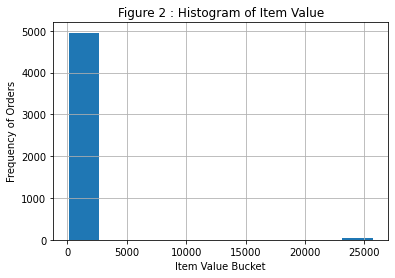

In [11]:
# Calculate Average Item Cost and Visualize Result

df['cost_per_item'] = df.apply(lambda x: x.order_amount / x.total_items, axis=1)
print(df['cost_per_item'].mean())
plt = df.cost_per_item.hist()

plt.set_title('Figure 2 : Histogram of Item Value')
plt.set_xlabel('Item Value Bucket')
plt.set_ylabel('Frequency of Orders')

* There is again an outlier with an item quantity of $25,000. This is incredibly high, and should be investigated further.

* Since each shop sells a different kind of shoe, it is possible that there is an extremely high-valued shoe, so I'll see what stores are selling these high value shoes.

In [30]:
high_cost_per_item_df = df.loc[df.cost_per_item > 5000]

shop_id_high_cost_per_item = high_cost_per_item_df.shop_id.unique().tolist()
user_id_high_cost_per_item = high_cost_per_item_df.user_id.unique().tolist()

shop_id_all = df.shop_id.unique().tolist()
user_id_all = df.user_id.unique().tolist()
print("There are {} unique shop IDs with high cost per item, {} unique users with high cost per item. This is shop {}.".format(len(shop_id_high_cost_per_item), len(user_id_high_cost_per_item), shop_id_high_cost_per_item[0]))
print("There are {} unique shop IDs overall, {} unique users overall".format(len(shop_id_all), len(user_id_all)))
print("\n")
low_cost_per_item_df = df.loc[df.shop_id != 78]
print("Cost Per Item excluding Store 78: ${}".format(round(low_cost_per_item_df['cost_per_item'].mean(), 2)))
print("Cost Per Item including all stores ${}".format(round(df['cost_per_item'].mean(), 2)))


There are 1 unique shop IDs with high cost per item, 45 unique users with high cost per item. This is shop 78.
There are 100 unique shop IDs overall, 301 unique users overall


Cost Per Item excluding Store 78: $152.48
Cost Per Item including all stores $387.74


# Wholesale Stores?

There are 1 unique shop IDs with high Average Order Quantity, 1 unique users with high Average Order Quantity. This is shop 42.
There are 100 unique shop IDs overall, 301 unique users overall


Average Order Amount excluding Store 42: $754.79
Average Order Amount including all stores $3145.13


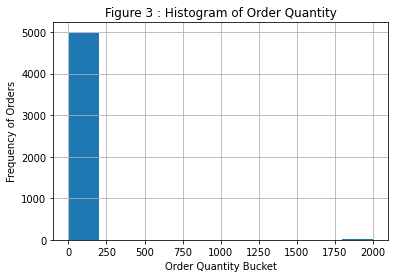

In [29]:
plt = df.total_items.hist()
plt.set_title('Figure 3 : Histogram of Order Quantity')
plt.set_xlabel('Order Quantity Bucket')
plt.set_ylabel('Frequency of Orders')

high_ord_qty_df = df.loc[df.total_items > 250]

shop_id_high_ord_qty_item = high_ord_qty_df.shop_id.unique().tolist()
user_id_high_ord_qty_item = high_ord_qty_df.user_id.unique().tolist()

print("There are {} unique shop IDs with high Average Order Quantity, {} unique users with high Average Order Quantity. This is shop {}.".format(len(shop_id_high_ord_qty_item), len(user_id_high_ord_qty_item), shop_id_high_ord_qty_item[0]))
print("There are {} unique shop IDs overall, {} unique users overall".format(len(shop_id_all), len(user_id_all)))
print("\n")
low_ord_qty_df = df.loc[df.shop_id != 42]
print("Average Order Amount excluding Store 42: ${}".format(round(low_ord_qty_df['order_amount'].mean(), 2)))
print("Average Order Amount including all stores ${}".format(round(df['order_amount'].mean(), 2)))

* There seems to be a store that sells wholesale to one client, as their average order quantity is 2000 pairs.
* We could separate the final metric into a wholesale and non-wholesale metric

The AOV excluding Store 42 is $754.79.

# Median / Percentiles

If we want to include all stores and still interested in order value (not item value), then the best solution may be to use medians or some form of percentiles.



In [47]:
print("25th Percentile Order Amount: ${}".format(df.order_amount.quantile(0.25)))
print("50th Percentile Order Amount: ${}".format(df.order_amount.quantile(0.50)))
print("75th Percentile Order Amount: ${}".format(df.order_amount.quantile(0.75)))
print("90th Percentile Order Amount: ${}".format(df.order_amount.quantile(0.90)))

25th Percentile Order Amount: $163.0
50th Percentile Order Amount: $284.0
75th Percentile Order Amount: $390.0
90th Percentile Order Amount: $531.0
